In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

Epoch 1/200
170/170 [==============================] - 4s 8ms/step - loss: 18.1065 - mae: 18.1065 - val_loss: 14.2410 - val_mae: 14.2410
Epoch 2/200
170/170 [==============================] - 1s 4ms/step - loss: 10.9782 - mae: 10.9782 - val_loss: 8.9375 - val_mae: 8.9375
Epoch 3/200
170/170 [==============================] - 1s 5ms/step - loss: 9.8072 - mae: 9.8072 - val_loss: 8.6723 - val_mae: 8.6723
Epoch 4/200
170/170 [==============================] - 2s 14ms/step - loss: 9.5436 - mae: 9.5436 - val_loss: 8.5601 - val_mae: 8.5601
Epoch 5/200
170/170 [==============================] - 2s 9ms/step - loss: 9.3268 - mae: 9.3268 - val_loss: 8.6389 - val_mae: 8.6389
Epoch 6/200
170/170 [==============================] - 2s 9ms/step - loss: 9.1012 - mae: 9.1012 - val_loss: 8.5782 - val_mae: 8.5782
Epoch 7/200
170/170 [==============================] - 1s 9ms/step - loss: 9.0739 - mae: 9.0739 - val_loss: 8.6457 - val_mae: 8.6457
Epoch 8/200
170/170 [==============================] - 1s 9ms/

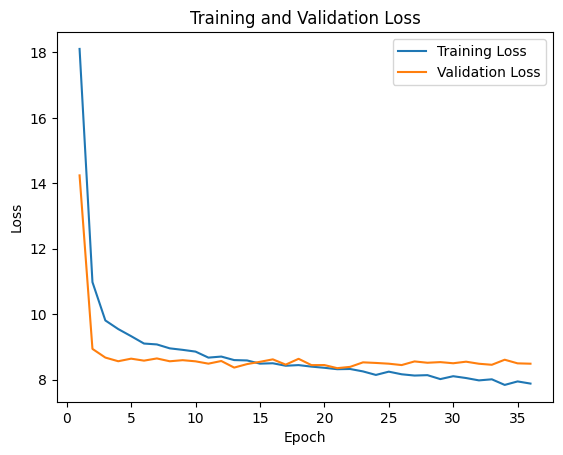

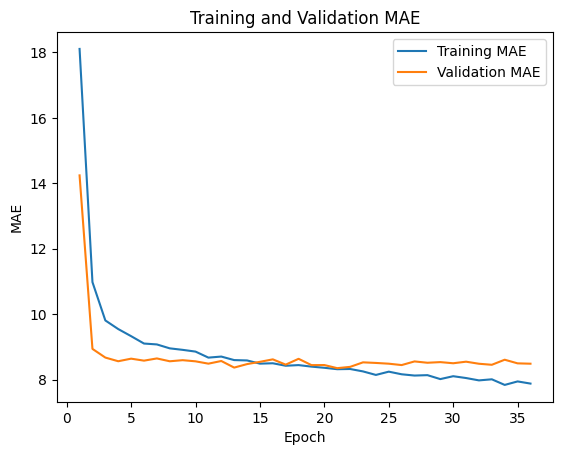

In [2]:
#Loads the dataset from github
data = pd.read_csv("https://raw.githubusercontent.com/ML-Racer-Performance-Prediction/NASCAR/main/Documentation/NASCAR%20Full%20Stats%20(2).csv")

# Separates the features and target
X = data.drop('EndingPosition', axis=1)
Y = data['EndingPosition']

# One-hot encoding the categorical features
categorical_cols = ['Track', 'Driver', 'Sponsor', 'Owner', 'CarManufacturer', 'TrackType']
numerical_cols = ['StartingPosition', 'CarNumber', 'Length']

label_encoder = LabelEncoder()
for col in categorical_cols:
    X[col] = label_encoder.fit_transform(X[col])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorical_transformer = categorical_transformer.fit(X[categorical_cols])
X_categorical = categorical_transformer.transform(X[categorical_cols]).toarray()

# Feature scaling on numerical features
numerical_transformer = StandardScaler()
X_numerical = numerical_transformer.fit_transform(X[numerical_cols])

# Combines the categorical and numerical features together again
X_combined = pd.concat([pd.DataFrame(X_categorical), pd.DataFrame(X_numerical)], axis=1)

'''
# Splits the dataset. 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_combined, Y, test_size=0.2, random_state=14)
'''

X_train = X_combined
y_train = Y

#'''
#Loads the dataset from github
test_data = pd.read_csv("https://raw.githubusercontent.com/ML-Racer-Performance-Prediction/NASCAR/main/Documentation/NASCAR%202024%20Test.csv")

# Separates the features and target
test_X = test_data.drop('EndingPosition', axis=1)
test_Y = test_data['EndingPosition']


for col in categorical_cols:
    test_X[col] = label_encoder.fit_transform(test_X[col])


test_X_categorical = categorical_transformer.transform(test_X[categorical_cols]).toarray()

# Feature scaling on numerical features
numerical_transformer = StandardScaler()
test_X_numerical = numerical_transformer.fit_transform(test_X[numerical_cols])

# Combines the categorical and numerical features together again
test_X_combined = pd.concat([pd.DataFrame(test_X_categorical), pd.DataFrame(test_X_numerical)], axis=1)

X_test = test_X_combined
y_test = test_Y

#'''

# Build the MLP model. ReLU activation, 40% dropout, 4 hidden layers
MLP = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='relu')
])

# Compiles the model with SGD, lr of 0.001, and a momentum of 0.8
optimizer = SGD(learning_rate=0.001, momentum=0.8)
MLP.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

# Early stopping to prevent overfitting
stop_early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Training the model with a batch size of 32 and maximum of 200 epochs
history = MLP.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=[stop_early])

# Gets the loss histories
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

# Evaluates the model on the test set
test_loss = MLP.evaluate(X_test, y_test, verbose=0)
print(f'Test MAE: {test_loss}')

# Makes predictions
y_pred = MLP.predict(X_test)

# Calculates MAE, MSE, and R-squared, then prints results
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plots the training and validation loss
plt.figure()
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plots the training and validation MAE
plt.figure()
plt.plot(range(1, len(train_mae) + 1), train_mae, label='Training MAE')
plt.plot(range(1, len(val_mae) + 1), val_mae, label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()